In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from a500_utils.helpers import make_tuple
from thermlib import thermfuncsII as tf
from thermlib import thermconst as tc
from importlib import reload
reload(tf)
import pandas as pd
import numpy as np
import scipy.integrate as integrate
plt.style.use('ggplot')

# helpers (from interactive_vaporflux.ipynb)
def theta_ft(h,ft_intercept,gamma):
    """
       input h (meters) and the coefficients for the linear
       profile for the free troposphere theta (ft_intercept (K)  and slope gamma (K/m))
       return the free tropospher theta at height h
    """
    theta_top = ft_intercept + h*gamma
    return theta_top

def dmixed_vars(the_vars,tstep,coeffs):
    """
      the_vars[0]= thetabar
      the_vars[1] = h
      the_vars[2] = qv
      
      surface flux from drag law with subsidence and diagnosed deltheta
    """
    #print('the_vars: ',the_vars,D,U)
    deltheta = theta_ft(the_vars[1],coeffs.ft_intercept,coeffs.ft_gamma) - the_vars[0]
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - the_vars[0])  #surface heat flux
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - the_vars[2])  #surface vapor flux
    Fint = -coeffs.k*F0  #entrainment heat flux
    
    #went = -Fint/deltheta  #entrainment velocity (positive upward)
    went = calc_went_NT(the_vars, coeffs, deltheta, F0, Fqv0)
    
    Fqvent = -went*( coeffs.ft_qv - the_vars[2])
    wsubs = -coeffs.D*the_vars[1]
    rho=1.
    cp=1004.
    derivs=np.empty_like(the_vars)
    derivs[0]=(F0 - Fint)/(the_vars[1]*rho) - coeffs.radcool/1004./the_vars[1]
    derivs[1] = went + wsubs
    derivs[2] = (Fqv0 - Fqvent)/the_vars[1]
    return derivs

def calc_went_NT(the_vars, coeffs, deltheta, F0, Fqv0):
    thetal_m = the_vars[0]
    qt_m = the_vars[2]
    zi = the_vars[1]
    dth = deltheta
    
    thetal_ft = thetal_m + dth
    qt_ft = coeffs.ft_qv
    
    dqt = qt_ft - qt_m
    
    # calculate thetal at z = 3000 m (take qt(z = 3000m) = qt(z = h), so delta_qt = dqt)
    gamma = 6e-3 
    thetal_3000 = thetal_ft + gamma*(3000-zi)
    LTS = thetal_3000 - coeffs.sst

    press=tf.find_press(zi)
    Ad,Bd,issat = tf.calc_ABcoeffs(thetal_ft,qt_ft,press)
    Aw,Bw,issat = tf.calc_ABcoeffs(thetal_m,qt_m,press)
    
    invert= tf.t_uos_thetal(thetal_m,qt_m,press)
    T_0 = invert.temp
    lv=tf.L_t(invert.temp)
    Cl =  (Ad*lv/tc.CPD - T_0/tc.EPS)
    del_thv_dry = Ad * dth + Bd * dqt
    del_thv_sat = Aw * dth + Bw * dqt
    
    # account for evaporative cooling
    ql_max = invert.ql
    Cl =  (Ad*lv/tc.CPD - T_0/tc.EPS)
    Del_thv = del_thv_dry - Cl * ql_max
    
    # calculate buoyancy integral terms
    rho = 1.
    #zi = the_vars[1]
    lcl_press=tf.LCL_thetal(thetal_m,qt_m)
    zb=tf.find_height(lcl_press)

    T1 = zb/zi
    T2 = 0.5 * zb**2 / zi**2
    T3 = (zi-zb)/zi
    T4 = 0.5 * (zi**2 - zb**2) / zi**2
    
    # calculate delta_Fr
    delta_Frstar = 82.0 # Wm^-2
    Frlambda = 7.9 # Wm^-2, using with CTL from Gesso
    delta_Fr = delta_Frstar - Frlambda*qt_ft*1000 # convert qt_ft to g kg^-1

    wtl_0=F0
    wqt_0=Fqv0
    #Del_F = coeffs.radcool/tc.CPD
    Del_F = delta_Fr/(tc.CPD*rho)
    term1 = wtl_0 * (Ad * (T1-T2) + Aw * (T3-T4))
    term2 = wqt_0 * (Bd * (T1-T2) + Bw * (T3-T4))
    term3 = Del_F * (Ad * T2      + Aw * T4)

    Theta_NE = term1 + term2 + term3
    
    # calculate w*
    wstar=(2.5*9.8/T_0*zi*Theta_NE)**(1/3.)
    
    # calculate chi*
    chi_star = Cl * ql_max / (del_thv_dry - del_thv_sat)
    
    # calculate del_m
    Del_m = del_thv_dry + chi_star * (2. - chi_star) * (del_thv_sat - del_thv_dry)
    
    # calculate we
    a2=15.
    Del_thv_NT = Del_thv / (1. + a2 * (1. - Del_m/Del_thv))
    
    A_NT = 0.2
    fac_NT = 2.5

    term4 = Del_thv_NT
    term5 = A_NT * fac_NT * (T2 * del_thv_dry + T4 * del_thv_sat)
    denominator = term4 + term5

    we = A_NT * fac_NT * Theta_NE / denominator
    
    return we
    
    
    
def calc_lcl(row,psfc):
    """
      find the lcl (in m) for a row in the dataframe
    """
    Tdew = tf.tmr(row['qv'],psfc)
    LCL = tf.LCL(Tdew,row['theta'],psfc)  #kPa
    #
    # rough approximation:  10 kPa = 1 km
    #
    delp=psfc - LCL
    lcl_h = delp*100.
    return lcl_h


def calc_sfc_theta_flux(row,coeffs):
    F0 = coeffs.U*coeffs.Cd*(coeffs.sst - row['theta'])  #surface heat flux
    return F0

def calc_sfc_qvap_flux(row,coeffs):
    Fqv0 = coeffs.U*coeffs.Cd*(coeffs.qsfc - row['qv'])
    return Fqv0

def calc_entflux_theta(row,coeffs):
    flux_ent = -coeffs.k*row['T_flux_0']
    return flux_ent

def calc_went(row,coeffs):
    went = -row['entflux_theta']/row['deltheta']
    return went
    
def calc_entflux_qv(row,coeffs):
    flux_ent =  -row['went']*( coeffs.ft_qv - row['qv'])
    return flux_ent



In [2]:
def write_hdf(sst, ft_qv):

    dtout=10.  #minutes
    end_time=8*24.   #hours
    del_time=dtout*60. #seconds
    end_time=end_time*3600. #seconds
    #sst=297
    D=5.e-6  #s-1
    U=7  #m/s
    psfc=100. #kPa
    qsfc=tf.qs_tp(sst,psfc)
    ft_intercept = 292 #K
    ft_gamma = 6.e-3  #K/m
    #ft_qv = 2.e-3
    k=0.2  #entrainment efficiency
    Cd = 1.e-3  #drag coefficient
    tspan = np.arange(0.,end_time,del_time)
    vars_init=[285.,400.,8.e-3]  #theta (K), height (m) qv (kg/kg) to start
    the_tup=dict(D=D,U=U,sst=sst,ft_intercept=ft_intercept,ft_gamma=ft_gamma,
                 qsfc=qsfc,ft_qv=ft_qv,k=k,Cd=Cd,radcool=30.)
    the_tup=make_tuple(the_tup,'coeffs')
    output=integrate.odeint(dmixed_vars, vars_init, tspan,(the_tup,))
    result=pd.DataFrame.from_records(output,columns=['theta','h','qv'])
    result['time']=tspan/3600./24.  #days
    result['deltheta'] = theta_ft(result['h'].values,ft_intercept,ft_gamma) - result['theta']
    result['delqv'] = ft_qv - result['qv']
    result['LCL']=result.apply(calc_lcl,axis=1,args=(psfc,))
    result['q_flux_0']=result.apply(calc_sfc_qvap_flux,axis=1,args=(the_tup,))
    result['T_flux_0']=result.apply(calc_sfc_theta_flux,axis=1,args=(the_tup,))  
    result['thick'] = result['h'] - result['LCL']
    result['entflux_theta']=result.apply(calc_entflux_theta,axis=1,args=(the_tup,))
    result['went'] = result.apply(calc_went,axis=1,args=(the_tup,))
    result['entflux_qv']=result.apply(calc_entflux_qv,axis=1,args=(the_tup,))
    cooling = np.empty_like(result['time'].values)
    cooling[:] = the_tup.radcool
    result['radcool']  = cooling

    with pd.HDFStore('dumpvapor.h5','w') as f:
        f.put('profile',result,format='table')
    
    return None

# ==============================================================

# main function
def calc_nicholls_turton(sst, ft_qv):
    
    write_hdf(sst, ft_qv)
    
    # grab HDF5 file 
    with pd.HDFStore('dumpvapor.h5') as f:
        df_result=f['profile']

    # last time step into named tupple
    out=df_result.iloc[-1]
    steady_state=make_tuple(out.to_dict())
    steady_state
        
    # calculate theta_v jumps
    dth=steady_state.deltheta
    dqt=steady_state.delqv
    thetal_m=steady_state.theta
    qt_m=steady_state.qv
    h=steady_state.h
    press=tf.find_press(steady_state.h)   #kPa
    thetal_ft = steady_state.theta + dth
    qt_ft = steady_state.qv + dqt
    zb = steady_state.LCL
    zi = steady_state.h
    we = steady_state.went
    
    # calculate thetal at z = 3000 m (take qt(z = 3000m) = qt(z = h), so delta_qt = dqt)
    gamma = 6e-3 
    thetal_3000 = thetal_ft + gamma*(3000-h)
    LTS = thetal_3000 - steady_state.theta
    
    # calculate delta_Fr
    delta_Frstar = 82.0 # Wm^-2
    Frlambda = 7.9 # Wm^-2, using with CTL from Gesso
    delta_Fr = delta_Frstar - Frlambda*qt_ft*1000 # convert qt_ft to g kg^-1

    # calculate LWP
    rho = 1.
    LWP = 0.5*rho*(zi-zb)**2
    
    # put all relevant variables into array
    #out_dict = {"thetal_ml":thetal_m, "qt_ml":qt_m, "zi":zi, "zb":zb, "we":we, "LWP":LWP, "delta_Fr":delta_Fr, 
    #           "LTS":LTS, "dqt":dqt}
    #out_tup = make_tuple(out_dict)
    out_array = np.array([thetal_m, qt_m, zi, zb, we, LWP, delta_Fr, LTS, dqt])
    
    return out_array

In [3]:
# test functions
sst = 297
ft_qv = 2e-3

test_array = calc_nicholls_turton(sst, ft_qv)
print(test_array)

[  2.93332265e+02   8.95838764e-03   1.89759797e+03   1.09885082e+03
   5.10759377e-04   3.18998509e+05   6.62000000e+01   1.66677349e+01
  -6.95838764e-03]


In [12]:
ft_qv = np.linspace(2e-3,9e-3,7)
sst = np.linspace(280,300,7)

data_array = np.empty([ft_qv.shape[0],sst.shape[0],test_array.shape[0]])
for i in range(ft_qv.shape[0]):
    for j in range(sst.shape[0]):
        for k in range(test_array.shape[0]):
            out_array = calc_nicholls_turton(sst[j], ft_qv[i])
            data_array[i,j,k] = out_array[k]

(10, 10, 9)


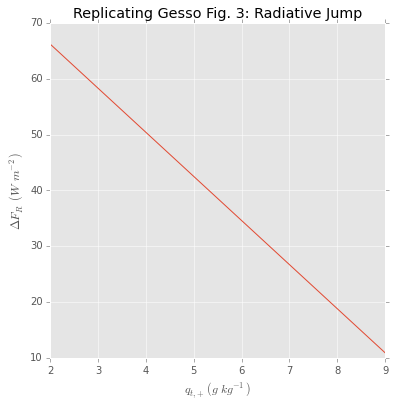

In [13]:
print(data_array.shape)

fig1,ax1 = plt.subplots(1,1,figsize=(6,6))

ax1.plot(ft_qv*1000,data_array[:,0,6])
ax1.set_title("Replicating Gesso Fig. 3: Radiative Jump")
ax1.set_xlabel(r"$q_{t,+}\ (g\ kg^{-1})$")
ax1.set_ylabel(r"$\Delta F_R\ (W\ m^{-2})$")

[[ 66.2         66.2         66.2         66.2         66.2         66.2
   66.2         66.2         66.2         66.2       ]
 [ 60.05555556  60.05555556  60.05555556  60.05555556  60.05555556
   60.05555556  60.05555556  60.05555556  60.05555556  60.05555556]
 [ 53.91111111  53.91111111  53.91111111  53.91111111  53.91111111
   53.91111111  53.91111111  53.91111111  53.91111111  53.91111111]
 [ 47.76666667  47.76666667  47.76666667  47.76666667  47.76666667
   47.76666667  47.76666667  47.76666667  47.76666667  47.76666667]
 [ 41.62222222  41.62222222  41.62222222  41.62222222  41.62222222
   41.62222222  41.62222222  41.62222222  41.62222222  41.62222222]
 [ 35.47777778  35.47777778  35.47777778  35.47777778  35.47777778
   35.47777778  35.47777778  35.47777778  35.47777778  35.47777778]
 [ 29.33333333  29.33333333  29.33333333  29.33333333  29.33333333
   29.33333333  29.33333333  29.33333333  29.33333333  29.33333333]
 [ 23.18888889  23.18888889  23.18888889  23.18888889  23.1888

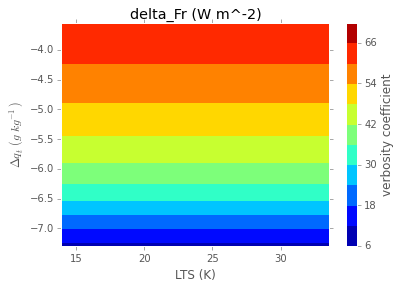

In [27]:
var_index = 6
var_names = ["thetal_m", "qt_m", "zi", "zb", "we", "LWP", "delta_Fr", "LTS", "dqt"]
units = ["K", "g kg^-1", "m", "m", "mm s^-1", "kg m^-2", "W m^-2", "K", "g kg^-1"]

#origin = 'lower'
origin = 'upper'

delta = 0.025

X, Y = np.meshgrid((data_array[0,:,7]), (data_array[0,:,8])*1000)
if var_index == 4:
    factor = 1000
elif var_index == 5:
    factor = 0.001
else:
    factor = 1
Z = (data_array[:,:,var_index]*factor)

nr, nc = Z.shape

# We are using automatic selection of contour levels;
# this is usually not such a good idea, because they don't
# occur on nice boundaries, but we do it here for purposes
# of illustration.
CS = plt.contourf(X, Y, Z, 10,
                  #[-1, -0.1, 0, 0.1],
                  #alpha=0.5,
                  cmap=plt.cm.jet,
                  origin=origin)

# Note that in the following, we explicitly pass in a subset of
# the contour levels used for the filled contours.  Alternatively,
# We could pass in additional levels to provide extra resolution,
# or leave out the levels kwarg to use all of the original levels.

plt.title("{} ({})".format(var_names[var_index], units[var_index]))
plt.xlabel('LTS (K)')
plt.ylabel(r'$\Delta q_t\ (g\ kg^{-1}) $')
# Make a colorbar for the ContourSet returned by the contourf call.
cbar = plt.colorbar(CS)
cbar.ax.set_ylabel('verbosity coefficient')
print(Z)